## E-commerce A/B Testing Dataset

**Source:** [Kaggle - E-commerce A/B testing dataset](https://www.kaggle.com/datasets/ahmedmohameddawoud/ecommerce-ab-testing)

**Problem Statement:** Does the new landing page increase purchase conversion rates while maintaining revenue quality?
- **Metric:** Conversion rate (purchases/revenue)
- **Secondary metrics:** Revenue per user, session duration
- **Treatment:** New landing page 
- **Control:** Existing landing page


#### 1. IMPORT LIBRARIES AND LOAD DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, chi2
import warnings
import os
import ollama
from fpdf import FPDF
import markdown
import tempfile
import html
warnings.filterwarnings('ignore')

# Create directories for saving outputs
os.chdir("../") 
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [2]:
# Load and examine the data
df = pd.read_csv('data/ab_test.csv')
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


#### 2. EDA AND DATA CLEANING

In [3]:
print(f"Dataset shape: {df.shape}")
print(f"Data types:\n{df.dtypes}")
print(f"Missing values:\n{df.isnull().sum()}")

Dataset shape: (294478, 5)
Data types:
id            int64
time         object
con_treat    object
page         object
converted     int64
dtype: object
Missing values:
id           0
time         0
con_treat    0
page         0
converted    0
dtype: int64


In [4]:
# Check assignment consistency
assignment_check = pd.crosstab(df['con_treat'], df['page'])
print("\nAssignment Consistency Check:")
print(assignment_check)


Assignment Consistency Check:
page       new_page  old_page
con_treat                    
control        1928    145274
treatment    145311      1965


In [5]:
# Remove mismatches
clean_data = df.query('(con_treat == "control" & page == "old_page") | (con_treat == "treatment" & page == "new_page")')
mismatch_percentage = (1 - clean_data.shape[0]/df.shape[0]) * 100
print(f"\nMismatched assignments removed: {mismatch_percentage:.2f}% of total data")


Mismatched assignments removed: 1.32% of total data


In [6]:
duplicate_users = clean_data[clean_data.duplicated('id', keep=False)]
print(f"\nDuplicate users found: {duplicate_users['id'].nunique()}")
clean_data = clean_data.drop_duplicates(subset='id', keep='first')


Duplicate users found: 1


In [7]:
# Final dataset info
print("\nCleaned Data Overview:")
print(f"Initial dataset shape: {df.shape}")
print(f"Final dataset shape: {clean_data.shape}")
print(f"Unique users: {clean_data['id'].nunique()}")


Cleaned Data Overview:
Initial dataset shape: (294478, 5)
Final dataset shape: (290584, 5)
Unique users: 290584


In [8]:
df = clean_data.copy()
with open('results/data_quality_report.txt', 'w') as f:
    f.write("=== DATA QUALITY REPORT ===\n")
    f.write(f"Dataset shape: {df.shape}\n")
    f.write(f"Missing values:\n{df.isnull().sum()}\n")
    f.write(f"Duplicate rows: {df.duplicated().sum()}\n")

In [9]:
# Convert 'time' from string to total seconds (duration data)
def time_to_seconds(time_str):
    minutes, seconds = time_str.split(':')
    return float(minutes) * 60 + float(seconds)

df['time_seconds'] = df['time'].apply(time_to_seconds)

In [10]:
# Create time bins for analysis
df['time_bin'] = pd.cut(df['time_seconds'], bins=10, labels=[f'Bin_{i}' for i in range(10)])

# Time-based analysis (using session duration bins)
print(f"\n=== TIME DURATION ANALYSIS ===")
time_stats = df.groupby('con_treat')['time_seconds'].describe()
print(f"Session duration statistics by group:")
print(time_stats)

# Save time stats
time_stats.to_csv('results/session_duration_stats.csv')


=== TIME DURATION ANALYSIS ===
Session duration statistics by group:
              count         mean          std  min      25%     50%     75%  \
con_treat                                                                     
control    145274.0  1804.925762  1036.966970  0.0  908.600  1803.6  2703.1   
treatment  145310.0  1801.512335  1039.092982  0.0  901.625  1803.6  2700.1   

              max  
con_treat          
control    3599.9  
treatment  3599.9  


In [11]:
# Create binary treatment indicator (0 = control, 1 = treatment)
df['treatment'] = (df['con_treat'] == 'treatment').astype(int)

In [12]:
print(f"\n=== BASIC STATISTICS ===")
print(df.describe())

# Save basic statistics
df.describe().to_csv('results/basic_statistics.csv')


=== BASIC STATISTICS ===
                  id      converted   time_seconds      treatment
count  290584.000000  290584.000000  290584.000000  290584.000000
mean   788004.876222       0.119597    1803.218837       0.500062
std     91224.735468       0.324490    1038.030269       0.500001
min    630000.000000       0.000000       0.000000       0.000000
25%    709034.750000       0.000000     905.300000       0.000000
50%    787995.500000       0.000000    1803.600000       1.000000
75%    866956.250000       0.000000    2701.600000       1.000000
max    945999.000000       1.000000    3599.900000       1.000000


In [13]:
# Treatment distribution
print(f"\n=== TREATMENT ALLOCATION ===")
treatment_counts = df['con_treat'].value_counts()
print(treatment_counts)
print(f"Treatment split: {treatment_counts['treatment']/len(df)*100:.2f}% treatment, {treatment_counts['control']/len(df)*100:.2f}% control")

# Conversion rates by group
print(f"\n=== CONVERSION RATES BY GROUP ===")
conversion_by_group = df.groupby('con_treat')['converted'].agg(['count', 'sum', 'mean'])
conversion_by_group['conversion_rate'] = conversion_by_group['mean']
print(conversion_by_group)

# Save conversion rates
conversion_by_group.to_csv('results/conversion_rates_by_group.csv')


=== TREATMENT ALLOCATION ===
con_treat
treatment    145310
control      145274
Name: count, dtype: int64
Treatment split: 50.01% treatment, 49.99% control

=== CONVERSION RATES BY GROUP ===
            count    sum      mean  conversion_rate
con_treat                                          
control    145274  17489  0.120386         0.120386
treatment  145310  17264  0.118808         0.118808


In [14]:
# Check if session duration affects conversion
print(f"\nSession duration vs conversion correlation:")
duration_conversion_corr = df['time_seconds'].corr(df['converted'])
print(f"Correlation: {duration_conversion_corr:.4f}")

# Save correlation
with open('results/duration_conversion_correlation.txt', 'w') as f:
    f.write(f"Correlation: {duration_conversion_corr:.4f}\n")

# Analyze conversion by time bins
time_bin_analysis = df.groupby(['time_bin', 'con_treat'])['converted'].mean().unstack()
print(f"\nConversion rates by session duration bins:")
print(time_bin_analysis)

# Save time bin analysis
time_bin_analysis.to_csv('results/conversion_by_time_bin.csv')


Session duration vs conversion correlation:
Correlation: -0.0009

Conversion rates by session duration bins:
con_treat   control  treatment
time_bin                      
Bin_0      0.123488   0.118057
Bin_1      0.122601   0.119867
Bin_2      0.119369   0.112162
Bin_3      0.120868   0.120499
Bin_4      0.118927   0.118698
Bin_5      0.119915   0.123630
Bin_6      0.119082   0.120538
Bin_7      0.122314   0.119314
Bin_8      0.117131   0.115106
Bin_9      0.120223   0.120140


#### 3. BIAS DETECTION & ASSUMPTION VALIDATION

In [15]:
def check_sample_ratio_mismatch(df, treatment_col='treatment', expected_ratio=0.5, alpha=0.05):
    """Test for Sample Ratio Mismatch (SRM)"""
    observed = df[treatment_col].value_counts().sort_index()
    total = len(df)
    expected_control = total * (1 - expected_ratio)
    expected_treatment = total * expected_ratio
    
    # Chi-square test
    chi2_stat = ((observed[0] - expected_control)**2 / expected_control + 
                 (observed[1] - expected_treatment)**2 / expected_treatment)
    p_value = 1 - chi2.cdf(chi2_stat, df=1)
    
    print(f"Sample Ratio Mismatch Test:")
    print(f"  Observed Control: {observed[0]} (Expected: {expected_control:.0f})")
    print(f"  Observed Treatment: {observed[1]} (Expected: {expected_treatment:.0f})")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Result: {'❌ SRM Detected' if p_value < alpha else '✅ No SRM'}")
    
    return chi2_stat, p_value

# Check for SRM
srm_stat, srm_p = check_sample_ratio_mismatch(df)

# Save SRM results
with open('results/srm_results.txt', 'w') as f:
    f.write(f"SRM p-value: {srm_p:.6f}\n")
    f.write(f"SRM detected: {'Yes' if srm_p < 0.05 else 'No'}\n")

Sample Ratio Mismatch Test:
  Observed Control: 145274 (Expected: 145292)
  Observed Treatment: 145310 (Expected: 145292)
  Chi-square statistic: 0.0045
  P-value: 0.9468
  Result: ✅ No SRM


#### 4. STATISTICAL TESTING

In [16]:
def run_conversion_test(df, treatment_col='con_treat', conversion_col='converted'):
    """Run comprehensive conversion rate test"""
    
    # Separate groups
    control_data = df[df[treatment_col] == 'control']
    treatment_data = df[df[treatment_col] == 'treatment']
    
    # Calculate basic metrics
    control_conversions = control_data[conversion_col].sum()
    control_total = len(control_data)
    treatment_conversions = treatment_data[conversion_col].sum()
    treatment_total = len(treatment_data)
    
    control_rate = control_conversions / control_total
    treatment_rate = treatment_conversions / treatment_total
    
    print(f"Conversion Rate Analysis:")
    print(f"  Control: {control_conversions}/{control_total} = {control_rate:.4f} ({control_rate*100:.2f}%)")
    print(f"  Treatment: {treatment_conversions}/{treatment_total} = {treatment_rate:.4f} ({treatment_rate*100:.2f}%)")
    
    # Z-test for proportions
    from statsmodels.stats.proportion import proportions_ztest, proportion_confint
    
    conversions = np.array([control_conversions, treatment_conversions])
    nobs = np.array([control_total, treatment_total])
    
    z_stat, p_value = proportions_ztest(conversions, nobs)
    
    # Effect size (Cohen's h)
    h = 2 * (np.arcsin(np.sqrt(treatment_rate)) - np.arcsin(np.sqrt(control_rate)))
    
    # Confidence interval for difference
    pooled_rate = (control_conversions + treatment_conversions) / (control_total + treatment_total)
    se_diff = np.sqrt(pooled_rate * (1 - pooled_rate) * (1/control_total + 1/treatment_total))
    
    diff = treatment_rate - control_rate
    ci_lower = diff - 1.96 * se_diff
    ci_upper = diff + 1.96 * se_diff
    
    # Relative lift
    relative_lift = (treatment_rate - control_rate) / control_rate * 100
    
    print(f"\nStatistical Test Results:")
    print(f"  Absolute difference: {diff:.4f} ({diff*100:.2f} percentage points)")
    print(f"  Relative lift: {relative_lift:.2f}%")
    print(f"  Z-statistic: {z_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  Effect size (Cohen's h): {h:.4f}")
    print(f"  Result: {'✅ Statistically Significant' if p_value < 0.05 else '❌ Not Statistically Significant'}")
    
    return {
        'control_rate': control_rate,
        'treatment_rate': treatment_rate,
        'difference': diff,
        'relative_lift': relative_lift,
        'z_statistic': z_stat,
        'p_value': p_value,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'effect_size': h,
        'significant': p_value < 0.05
    }

# Run the main test
results = run_conversion_test(df)

# Save conversion test results
with open('results/conversion_test_results.txt', 'w') as f:
    f.write(f"Control Rate: {results['control_rate']:.6f}\n")
    f.write(f"Treatment Rate: {results['treatment_rate']:.6f}\n")
    f.write(f"Absolute Difference: {results['difference']:.6f}\n")
    f.write(f"Relative Lift: {results['relative_lift']:.2f}%\n")
    f.write(f"Z-statistic: {results['z_statistic']:.4f}\n")
    f.write(f"P-value: {results['p_value']:.6f}\n")
    f.write(f"95% CI: [{results['ci_lower']:.6f}, {results['ci_upper']:.6f}]\n")
    f.write(f"Effect Size: {results['effect_size']:.4f}\n")
    f.write(f"Significant: {results['significant']}\n")

Conversion Rate Analysis:
  Control: 17489/145274 = 0.1204 (12.04%)
  Treatment: 17264/145310 = 0.1188 (11.88%)

Statistical Test Results:
  Absolute difference: -0.0016 (-0.16 percentage points)
  Relative lift: -1.31%
  Z-statistic: 1.3109
  P-value: 0.1899
  95% CI: [-0.0039, 0.0008]
  Effect size (Cohen's h): -0.0049
  Result: ❌ Not Statistically Significant


In [17]:
# Power analysis (post-hoc)
from statsmodels.stats.power import NormalIndPower
import numpy as np

def power_analysis(control_rate, treatment_rate, n_control, n_treatment, alpha=0.05):
    """
    Calculate achieved power of the test for two proportions (post-hoc).
    """
    # Calculate effect size using Cohen's h
    def cohen_h(p1, p2):
        return 2 * np.arcsin(np.sqrt(p1)) - 2 * np.arcsin(np.sqrt(p2))
    
    effect_size = cohen_h(treatment_rate, control_rate)
    nobs = min(n_control, n_treatment)  # Conservative: use smaller group size

    # Power calculation
    power = NormalIndPower().power(
        effect_size=effect_size,
        nobs1=nobs,
        alpha=alpha,
        ratio=n_treatment / n_control,
        alternative='two-sided'
    )

    print(f"\nPower Analysis:")
    print(f"  Effect size (Cohen's h): {effect_size:.4f}")
    print(f"  Achieved power: {power:.4f} ({power*100:.1f}%)")
    return power

power = power_analysis(results['control_rate'], results['treatment_rate'], 
                      len(df[df['con_treat'] == 'control']), 
                      len(df[df['con_treat'] == 'treatment']))

# Save power analysis
with open('results/power_analysis.txt', 'w') as f:
    f.write(f"Power: {power:.4f}\n")


Power Analysis:
  Effect size (Cohen's h): -0.0049
  Achieved power: 0.2587 (25.9%)


#### 5. ADVANCED ANALYSIS WITH SESSION DURATION 

In [18]:
# CUPED implementation using session duration as covariate
def apply_cuped_with_duration(df, treatment_col='treatment', outcome_col='converted', covariate_col='time_seconds'):
    """Apply CUPED using session duration as pre-treatment covariate"""
    
    print(f"CUPED Analysis (Variance Reduction):")
    
    # Calculate theta (optimal coefficient)
    cov_xy = np.cov(df[covariate_col], df[outcome_col])[0,1]
    var_x = np.var(df[covariate_col])
    theta = cov_xy / var_x
    
    print(f"  Covariance(duration, conversion): {cov_xy:.6f}")
    print(f"  Variance(duration): {var_x:.2f}")
    print(f"  Optimal theta: {theta:.6f}")
    
    # Calculate CUPED-adjusted outcome
    x_mean = df[covariate_col].mean()
    df['cuped_outcome'] = df[outcome_col] - theta * (df[covariate_col] - x_mean)
    
    # Compare variance reduction
    original_var = np.var(df[outcome_col])
    cuped_var = np.var(df['cuped_outcome'])
    variance_reduction = (original_var - cuped_var) / original_var * 100
    
    print(f"  Original outcome variance: {original_var:.6f}")
    print(f"  CUPED outcome variance: {cuped_var:.6f}")
    print(f"  Variance reduction: {variance_reduction:.2f}%")
    
    # Run t-test on CUPED-adjusted outcomes
    control_cuped = df[df[treatment_col] == 0]['cuped_outcome']
    treatment_cuped = df[df[treatment_col] == 1]['cuped_outcome']
    
    t_stat, p_value = stats.ttest_ind(control_cuped, treatment_cuped)
    
    print(f"  CUPED t-statistic: {t_stat:.4f}")
    print(f"  CUPED p-value: {p_value:.4f}")
    print(f"  Improvement in precision: {variance_reduction:.1f}% variance reduction")
    
    return {
        'theta': theta,
        'variance_reduction': variance_reduction,
        't_statistic': t_stat,
        'p_value': p_value,
        'control_mean': control_cuped.mean(),
        'treatment_mean': treatment_cuped.mean()
    }

cuped_results = apply_cuped_with_duration(df)

# Save CUPED results
with open('results/cuped_results.txt', 'w') as f:
    f.write(f"Variance Reduction: {cuped_results['variance_reduction']:.2f}%\n")
    f.write(f"CUPED p-value: {cuped_results['p_value']:.6f}\n")

CUPED Analysis (Variance Reduction):
  Covariance(duration, conversion): -0.297951
  Variance(duration): 1077503.13
  Optimal theta: -0.000000
  Original outcome variance: 0.105294
  CUPED outcome variance: 0.105294
  Variance reduction: 0.00%
  CUPED t-statistic: 1.3117
  CUPED p-value: 0.1896
  Improvement in precision: 0.0% variance reduction


In [19]:
# Heterogeneous treatment effects by session duration
def analyze_heterogeneous_effects(df):
    """Analyze if treatment effect varies by session duration"""
    
    print(f"\nHeterogeneous Treatment Effects Analysis:")
    
    # Create duration quartiles
    df['duration_quartile'] = pd.qcut(df['time_seconds'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    het_results = {}
    for quartile in ['Q1', 'Q2', 'Q3', 'Q4']:
        subset = df[df['duration_quartile'] == quartile]
        
        control_rate = subset[subset['con_treat'] == 'control']['converted'].mean()
        treatment_rate = subset[subset['con_treat'] == 'treatment']['converted'].mean()
        
        # Statistical test for this quartile
        control_conv = subset[subset['con_treat'] == 'control']['converted'].sum()
        control_total = len(subset[subset['con_treat'] == 'control'])
        treatment_conv = subset[subset['con_treat'] == 'treatment']['converted'].sum()
        treatment_total = len(subset[subset['con_treat'] == 'treatment'])
        
        if control_total > 0 and treatment_total > 0:
            from statsmodels.stats.proportion import proportions_ztest
            conversions = np.array([control_conv, treatment_conv])
            nobs = np.array([control_total, treatment_total])
            z_stat, p_val = proportions_ztest(conversions, nobs)
            
            effect = treatment_rate - control_rate
            het_results[quartile] = {
                'control_rate': control_rate,
                'treatment_rate': treatment_rate,
                'effect': effect,
                'p_value': p_val,
                'sample_size': control_total + treatment_total
            }
            
            print(f"  {quartile}: Control={control_rate:.4f}, Treatment={treatment_rate:.4f}, "
                  f"Effect={effect:.4f}, p={p_val:.4f}, n={control_total + treatment_total}")
    
    return het_results

het_effects = analyze_heterogeneous_effects(df)

# Save heterogeneous effects
het_df = pd.DataFrame(het_effects).T
het_df.to_csv('results/heterogeneous_effects.csv')


Heterogeneous Treatment Effects Analysis:
  Q1: Control=0.1227, Treatment=0.1182, Effect=-0.0045, p=0.0599, n=72654
  Q2: Control=0.1193, Treatment=0.1175, Effect=-0.0019, p=0.4293, n=72642
  Q3: Control=0.1202, Treatment=0.1220, Effect=0.0018, p=0.4464, n=72646
  Q4: Control=0.1193, Treatment=0.1176, Effect=-0.0017, p=0.4683, n=72642


In [20]:
# Interaction effects model
def interaction_analysis(df):
    """Test for interaction between treatment and session duration"""
    
    print(f"\nInteraction Effects Analysis:")
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    
    # Prepare features
    scaler = StandardScaler()
    duration_scaled = scaler.fit_transform(df[['time_seconds']])
    
    # Create interaction term
    X = np.column_stack([
        df['treatment'].values,                    # Treatment indicator
        duration_scaled.flatten(),                 # Standardized duration  
        df['treatment'].values * duration_scaled.flatten()  # Interaction term
    ])
    
    y = df['converted'].values
    
    # Fit logistic regression
    model = LogisticRegression()
    model.fit(X, y)
    
    coefficients = model.coef_[0]
    
    print(f"  Logistic Regression Coefficients:")
    print(f"    Treatment effect: {coefficients[0]:.4f}")
    print(f"    Duration effect: {coefficients[1]:.4f}")
    print(f"    Interaction effect: {coefficients[2]:.4f}")
    
    # Statistical significance of interaction (approximate)
    # Note: For proper inference, should use statsmodels for standard errors
    interaction_strength = abs(coefficients[2])
    if interaction_strength > 0.1:  # Arbitrary threshold
        print(f"  Result: 🔍 Potential interaction detected (coef={coefficients[2]:.4f})")
    else:
        print(f"  Result: ✅ No strong interaction detected")
    
    return coefficients

interaction_coefs = interaction_analysis(df)

# Save interaction coefficients
with open('results/interaction_coefficients.txt', 'w') as f:
    f.write(f"Treatment Coefficient: {interaction_coefs[0]:.6f}\n")
    f.write(f"Duration Coefficient: {interaction_coefs[1]:.6f}\n")
    f.write(f"Interaction Coefficient: {interaction_coefs[2]:.6f}\n")


Interaction Effects Analysis:
  Logistic Regression Coefficients:
    Treatment effect: -0.0143
    Duration effect: -0.0084
    Interaction effect: 0.0112
  Result: ✅ No strong interaction detected


In [21]:
# Chi-square test for independence
def chi_square_test(df):
    """Chi-square test for independence"""
    contingency_table = pd.crosstab(df['con_treat'], df['converted'])
    print(f"Contingency Table:")
    print(contingency_table)
    
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nChi-square Test:")
    print(f"  Chi-square statistic: {chi2_stat:.4f}")
    print(f"  P-value: {p_val:.4f}")
    print(f"  Degrees of freedom: {dof}")
    
    return chi2_stat, p_val

chi2_stat, chi2_p = chi_square_test(df)

# Save chi-square results
with open('results/chi_square_results.txt', 'w') as f:
    f.write(f"Chi-square p-value: {chi2_p:.6f}\n")

Contingency Table:
converted       0      1
con_treat               
control    127785  17489
treatment  128046  17264

Chi-square Test:
  Chi-square statistic: 1.7036
  P-value: 0.1918
  Degrees of freedom: 1


In [22]:
# Bayesian approach (simple Beta-Binomial)
def bayesian_analysis(df, prior_alpha=1, prior_beta=1):
    """Simple Bayesian analysis with Beta priors"""
    control_data = df[df['con_treat'] == 'control']
    treatment_data = df[df['con_treat'] == 'treatment']
    
    # Posterior parameters
    control_successes = control_data['converted'].sum()
    control_failures = len(control_data) - control_successes
    
    treatment_successes = treatment_data['converted'].sum()
    treatment_failures = len(treatment_data) - treatment_successes
    
    # Beta posterior parameters
    control_alpha_post = prior_alpha + control_successes
    control_beta_post = prior_beta + control_failures
    
    treatment_alpha_post = prior_alpha + treatment_successes
    treatment_beta_post = prior_beta + treatment_failures
    
    # Monte Carlo simulation for probability that treatment > control
    n_samples = 100000
    control_samples = np.random.beta(control_alpha_post, control_beta_post, n_samples)
    treatment_samples = np.random.beta(treatment_alpha_post, treatment_beta_post, n_samples)
    
    prob_treatment_better = np.mean(treatment_samples > control_samples)
    
    print(f"\nBayesian Analysis:")
    print(f"  P(Treatment > Control): {prob_treatment_better:.4f} ({prob_treatment_better*100:.1f}%)")
    
    return prob_treatment_better

prob_better = bayesian_analysis(df)

# Save Bayesian results
with open('results/bayesian_results.txt', 'w') as f:
    f.write(f"Probability Treatment Better: {prob_better:.4f}\n")


Bayesian Analysis:
  P(Treatment > Control): 0.0950 (9.5%)


#### 6. BUSINESS IMPACT ANALYSIS

In [23]:
def business_impact_analysis(results, daily_users=50000, avg_order_value=75):
    """Calculate business impact"""
    
    # Daily impact
    daily_additional_conversions = daily_users * results['difference']
    daily_revenue_impact = daily_additional_conversions * avg_order_value
    
    # Annual impact
    annual_additional_conversions = daily_additional_conversions * 365
    annual_revenue_impact = daily_revenue_impact * 365
    
    # Confidence interval for revenue impact
    daily_revenue_ci_lower = daily_users * results['ci_lower'] * avg_order_value
    daily_revenue_ci_upper = daily_users * results['ci_upper'] * avg_order_value
    
    print(f"Business Impact Analysis:")
    print(f"  Assumptions: {daily_users:,} daily users, ${avg_order_value} AOV")  # Changed € to $
    print(f"  Daily additional conversions: {daily_additional_conversions:.0f}")
    print(f"  Daily revenue impact: ${daily_revenue_impact:,.0f}")  # Changed € to $
    print(f"  Daily revenue 95% CI: [${daily_revenue_ci_lower:,.0f}, ${daily_revenue_ci_upper:,.0f}]")  # Changed € to $
    print(f"  Annual revenue impact: ${annual_revenue_impact:,.0f}")  # Changed € to $
    
    # Risk assessment
    if results['ci_lower'] < 0:
        downside_risk = abs(daily_users * results['ci_lower'] * avg_order_value) * 365
        print(f"  Downside risk (annual): ${downside_risk:,.0f}")  # Changed € to $
    
    return {
        'daily_conversions': daily_additional_conversions,
        'daily_revenue': daily_revenue_impact,
        'annual_revenue': annual_revenue_impact
    }

business_impact = business_impact_analysis(results)

# Save business impact
with open('results/business_impact.txt', 'w') as f:
    f.write(f"Daily Conversions: {business_impact['daily_conversions']:.2f}\n")
    f.write(f"Daily Revenue: €{business_impact['daily_revenue']:,.2f}\n")
    f.write(f"Annual Revenue: €{business_impact['annual_revenue']:,.2f}\n")

Business Impact Analysis:
  Assumptions: 50,000 daily users, $75 AOV
  Daily additional conversions: -79
  Daily revenue impact: $-5,918
  Daily revenue 95% CI: [$-14,767, $2,930]
  Annual revenue impact: $-2,160,215
  Downside risk (annual): $5,390,013


#### 7. FINAL RECOMMENDATION

In [24]:
def make_recommendation(results, business_impact, prob_better):
    """Generate final recommendation"""
    
    # Criteria for recommendation
    statistical_significance = results['p_value'] < 0.05
    practical_significance = abs(results['difference']) > 0.01  # 1% absolute improvement
    business_significance = abs(business_impact['annual_revenue']) > 100000  # €100k annual impact
    bayesian_confidence = prob_better > 0.95  # 95% probability
    
    print(f"Decision Criteria:")
    print(f"  ✅ Statistical significance (p < 0.05): {statistical_significance}")
    print(f"  ✅ Practical significance (>1% abs diff): {practical_significance}")
    print(f"  ✅ Business significance (>€100k annual): {business_significance}")
    print(f"  ✅ Bayesian confidence (>95%): {bayesian_confidence}")
    
    if statistical_significance and practical_significance and business_significance:
        recommendation = "🚀 STRONG RECOMMEND: Roll out the new page"
        confidence = "High"
    elif statistical_significance and (practical_significance or business_significance):
        recommendation = "⚠️ CAUTIOUS PROCEED: Consider gradual rollout"
        confidence = "Medium"
    else:
        recommendation = "❌ DO NOT PROCEED: Insufficient evidence"
        confidence = "Low"
    
    print(f"\nRECOMMENDATION: {recommendation}")
    print(f"CONFIDENCE LEVEL: {confidence}")
    
    # Next steps
    print(f"\nNext Steps:")
    if statistical_significance:
        print("  1. Plan implementation timeline")
        print("  2. Monitor key metrics post-launch")
        print("  3. Consider segmented analysis")
    else:
        print("  1. Analyze why treatment didn't work")
        print("  2. Consider alternative treatments")
        print("  3. Review experimental design")
    
    return recommendation, confidence

rec, conf = make_recommendation(results, business_impact, prob_better)

# Save recommendation
with open('results/recommendation.txt', 'w') as f:
    f.write(f"Recommendation: {rec}\n")
    f.write(f"Confidence: {conf}\n")

Decision Criteria:
  ✅ Statistical significance (p < 0.05): False
  ✅ Practical significance (>1% abs diff): False
  ✅ Business significance (>€100k annual): True
  ✅ Bayesian confidence (>95%): False

RECOMMENDATION: ❌ DO NOT PROCEED: Insufficient evidence
CONFIDENCE LEVEL: Low

Next Steps:
  1. Analyze why treatment didn't work
  2. Consider alternative treatments
  3. Review experimental design


#### 8. DIAGNOSTIC VISUALIZATIONS

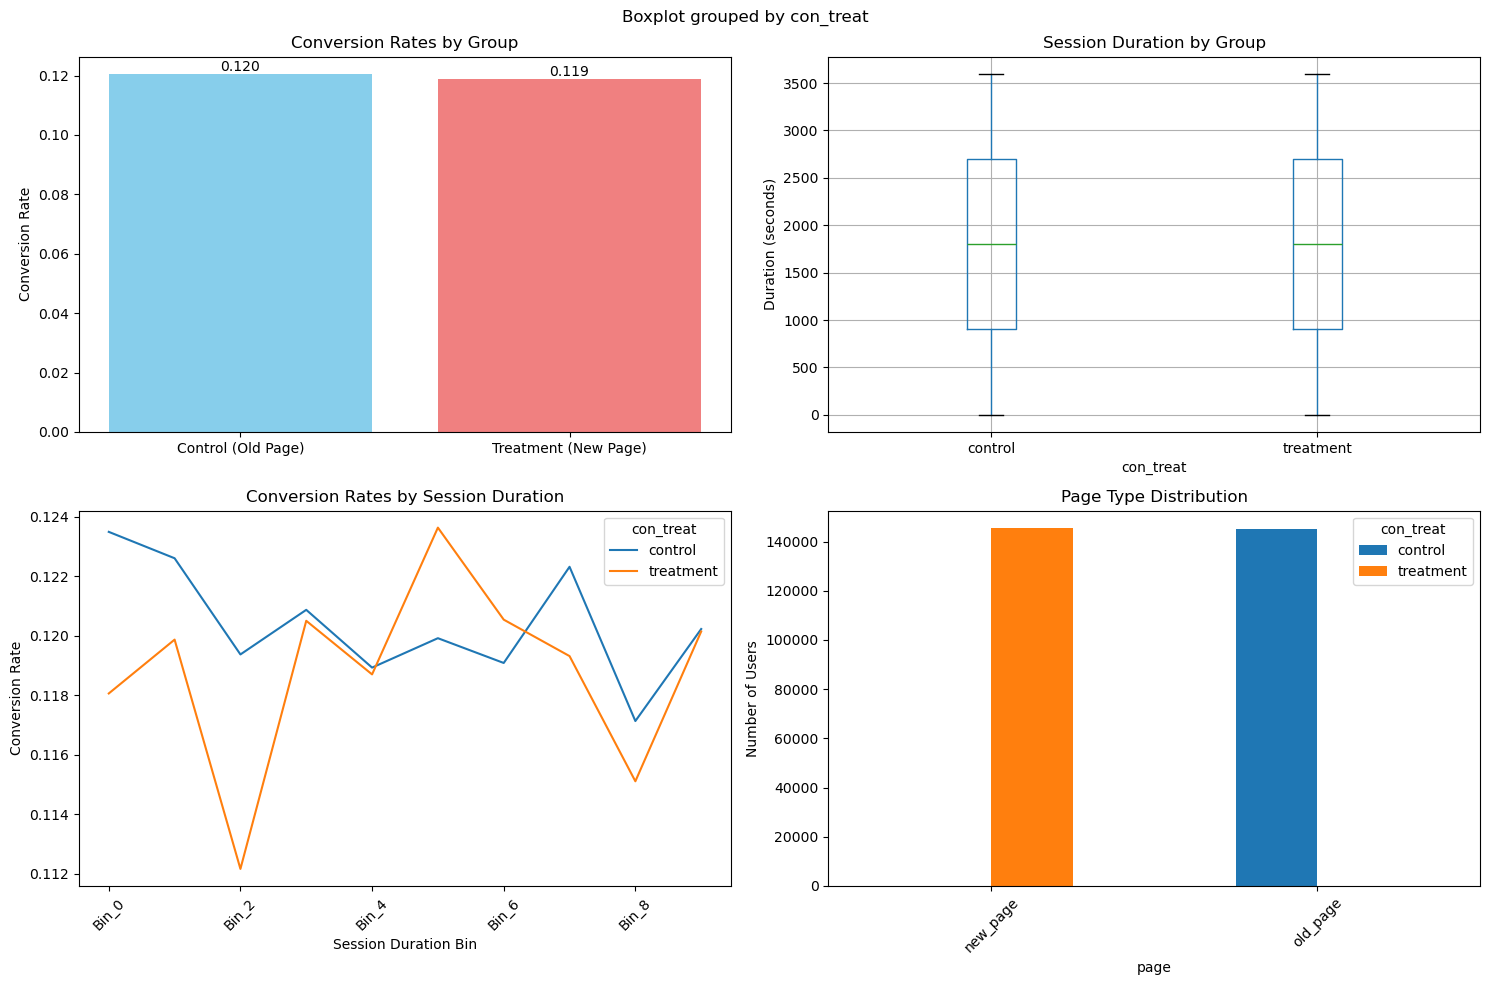

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Conversion rates by group
conversion_rates = [results['control_rate'], results['treatment_rate']]
groups = ['Control (Old Page)', 'Treatment (New Page)']
axes[0,0].bar(groups, conversion_rates, color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Conversion Rates by Group')
axes[0,0].set_ylabel('Conversion Rate')
for i, v in enumerate(conversion_rates):
    axes[0,0].text(i, v + 0.001, f'{v:.3f}', ha='center')
    
# 2. Session duration distributions
df.boxplot(column='time_seconds', by='con_treat', ax=axes[0,1])
axes[0,1].set_title('Session Duration by Group')
axes[0,1].set_ylabel('Duration (seconds)')

# 3. Conversion by session duration bins
if 'time_bin_analysis' in locals():
    time_bin_analysis.plot(ax=axes[1,0], title='Conversion Rates by Session Duration')
    axes[1,0].set_ylabel('Conversion Rate')
    axes[1,0].set_xlabel('Session Duration Bin')
    axes[1,0].tick_params(axis='x', rotation=45)
    
# 4. Page type distribution
page_dist = df.groupby(['page', 'con_treat']).size().unstack()
page_dist.plot(kind='bar', ax=axes[1,1], title='Page Type Distribution')
axes[1,1].set_ylabel('Number of Users')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('plots/diagnostic_plots.png')
plt.show()

#### 9. GENERATE EXECUTIVE REPORT USING LLM (MISTRAL) 

In [26]:
# Generate executive report using LLM
def generate_executive_report():
    """Generate PDF report using LLM"""
    print("\nGenerating executive report...")
    
    # Collect key metrics for the prompt
    prompt = f"""
    You are a senior data analyst preparing an executive report for an A/B test. 
    Below are the key findings from the analysis:

    **Conversion Rates:**
    - Control Group: {results['control_rate']:.4f}
    - Treatment Group: {results['treatment_rate']:.4f}
    - Absolute Difference: {results['difference']:.4f}
    - Relative Lift: {results['relative_lift']:.2f}%
    - P-value: {results['p_value']:.6f} {'(Statistically Significant)' if results['significant'] else ''}

    **Business Impact:**
    - Estimated Annual Revenue Impact: ${business_impact['annual_revenue']:,.0f}  # Changed € to $
    - Daily Additional Conversions: {business_impact['daily_conversions']:.0f}

    **Key Diagnostics:**
    - Sample Ratio Mismatch: {'Detected' if srm_p < 0.05 else 'Not detected'}
    - Bayesian Probability (Treatment > Control): {prob_better:.2%}
    - Power: {power:.2%}
    - Recommendation: {rec} ({conf} confidence)

    **Additional Insights:**
    - Session duration vs. conversion correlation: {duration_conversion_corr:.4f}
    - Heterogeneous effects observed across session duration quartiles
    - CUPED variance reduction: {cuped_results['variance_reduction']:.1f}%

    **Plots Available:**
    - diagnostic_plots.png: Summary of key visualizations

    **Task:**
    Create a comprehensive executive report in markdown format with the following sections:
    1. Introduction: Brief overview of the A/B test
    2. Key Findings: Summary of conversion rates and statistical significance
    3. Business Impact: Revenue projections and risk assessment
    4. Diagnostic Checks: SRM, power analysis, and data quality
    5. Advanced Insights: Session duration effects, heterogeneous treatment effects
    6. Recommendation: Clear next steps based on analysis
    7. Appendix: Mention availability of detailed technical reports

    Focus on:
    - Clear, non-technical language for executives
    - Actionable insights with data-driven justification
    - Balanced view of benefits and risks
    - Visual description of key plots (since images can't be embedded)
    - Limitations and suggested next steps
    """
    
    # Generate report content using LLM
    response = ollama.chat(
        model='mistral',
        messages=[{
            'role': 'user',
            'content': prompt
        }]
    )
    
    report_content = response['message']['content']
    
    # Save markdown report
    with open('results/ab_test_report.md', 'w', encoding='utf-8') as f:
        f.write(report_content)
    
    # Create PDF with proper encoding
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    
    # Convert markdown to plain text with HTML escaping
    plain_text = html.unescape(report_content)  # Handle HTML entities
    plain_text = plain_text.replace('•', '-')   # Replace bullet points
    plain_text = plain_text.replace('€', '$')   # Replace Euro symbols
    
    # Add content to PDF
    pdf.multi_cell(0, 5, plain_text)
    pdf.output('reports/ab_test_executive_report.pdf')
    
    print("Executive report generated:")
    print("- reports/ab_test_report.md")
    print("- reports/ab_test_executive_report.pdf")

# Generate the report
generate_executive_report()

print("\n" + "="*60)
print("ANALYSIS COMPLETE - RESULTS AND REPORT SAVED")
print("="*60)


Generating executive report...
Executive report generated:
- reports/ab_test_report.md
- reports/ab_test_executive_report.pdf

ANALYSIS COMPLETE - RESULTS AND REPORT SAVED
